In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *


# Model definition

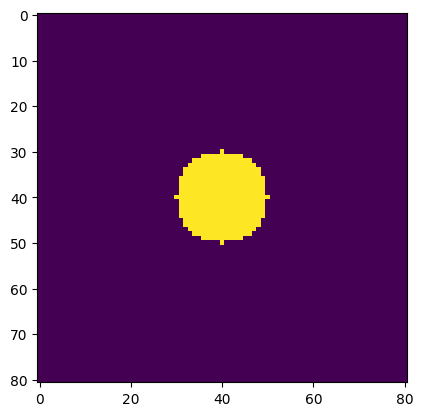

In [2]:
import numpy as np
def constant_disk(x,y,xs,ys,r):
  d = np.sqrt((x-xs)**2+(y-ys)**2)
  return np.heaviside(r-d,1)
oname = 'likelihood.dat'
# lambdaa = 20
nx = 81
ny = 81
r = 10 # radius
xsource = 0
ysource = 0
xmin = -40
xmax = 40
ymin = -40
ymax = 40
xp = np.linspace(xmin,xmax,nx,endpoint=True)
yp = np.linspace(ymin,ymax,ny,endpoint=True)
X,Y = np.meshgrid(xp,yp)
like = constant_disk(X,Y,xsource,ysource,r)
# print(like)
# print(X)
# print(Y)
# ## output to file
# ofile = open(oname,'w')
# ofile.write(f"{nx} {ny}\n")
# for j in range(nx):
#   s = ""
#   for i in range(ny):
#     s = s + str(like[i,j])+" "
#   s = s[:-1]+"\n"
#   print(s)
#   ofile.write(s)
# ofile.close()
plt.imshow(like)

In [3]:
env_shape = like.shape

In [4]:
state_grid = []

# State labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

state_count = 81 * 81

In [6]:
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 4, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West

reachable_states = np.array(reachable_states)

reachable_states.shape

In [8]:
# Reward function
def reward_func(s,a,sn,o):
    return np.where(sn == ((81*40) + 40), 1.0, 0.0)

In [9]:
observations = np.concatenate((like.flatten()[:,None], (1-like.flatten()[:,None])),axis=1)
observations = observations.reshape(state_count,1,2).repeat(4, axis=1) #Repeat for each action

In [12]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W'],
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[((81*40) + 40)]
)

[10/11/2023, 16:57:11] Instantiation of MDP Model:
[10/11/2023, 16:57:11] - 6561 states
[10/11/2023, 16:57:11] - 4 actions
[10/11/2023, 16:57:11] - At most 1 reachable states per state-action pair
[10/11/2023, 16:57:11] - Starting generation of transitions table
[Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[10/11/2023, 16:57:11]     > Done in 0.000s
[10/11/2023, 16:57:11] - Generation of state grid
[10/11/2023, 16:57:11] - Generating start probabilities table
[10/11/2023, 16:57:11] - Starting computation of reachable state probabilities from transition data
[10/11/2023, 16:57:11]     > Done in 0.000s
[10/11/2023, 16:57:11] POMDP particular parameters:
[10/11/2023, 16:57:11] - 2 observations
[10/11/2023, 16:57:11] - Starting of transitional observations for reachable states table
[10/11/2023, 16:57:11]     > Done in 0.001s
[10/11/2023, 16:57:11] - Starting gener

# MDP Solution

In [13]:
from src.mdp import VI_Solver

In [14]:
solver = VI_Solver(eps=1e-3)

In [15]:
solution, history = solver.solve(model, use_gpu=True)

[10/11/2023, 16:57:11] Sending Model to GPU...
[10/11/2023, 16:57:13]     > Done in 1.308s


  0%|          | 0/10000 [00:00<?, ?it/s]

[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


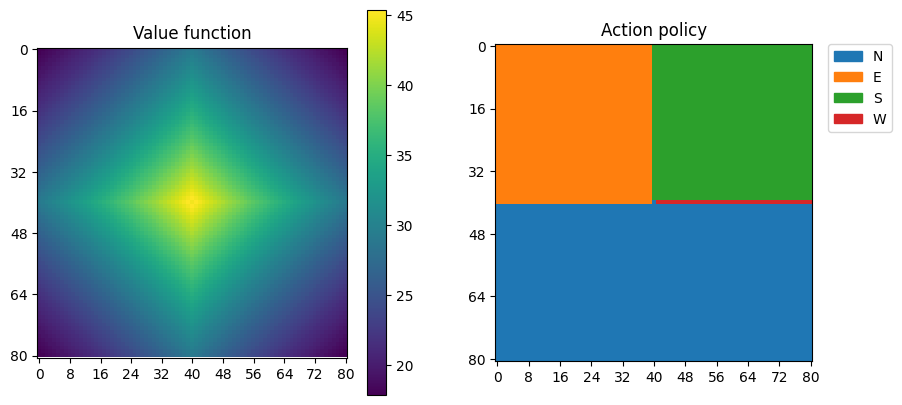

In [16]:
solution.plot()

# FSVI Solution

In [40]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [41]:
fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        expansions=100,
                                        horizon=200,
                                        mdp_policy=solution,
                                        # expand_prune_level=2,
                                        use_gpu=True)

Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


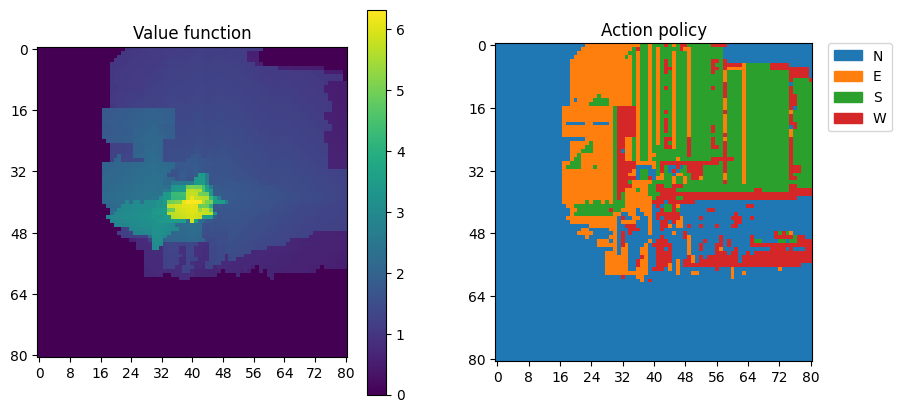

In [42]:
fsvi_solution.plot()

# Simulation

In [45]:
agent = Agent(model)
agent.value_function = fsvi_solution.to_cpu()

In [47]:
sim_hist = agent.simulate()

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation done:
	- Runtime (s): 1.194758
	- Steps: 215
	- Total rewards: 1.0
	- End state: s_40_40


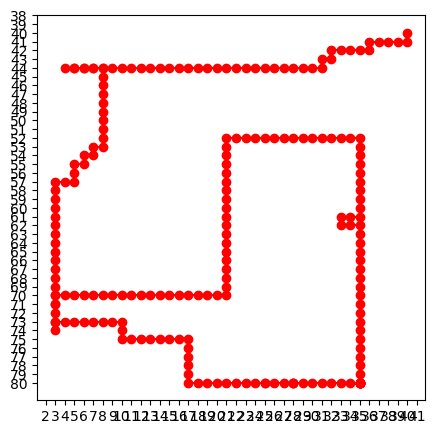

In [48]:
sim_hist.plot_simulation_steps()

In [49]:
sim_hist.save_simulation_video()

Video saved at 'Sim Videos/s6561-a4-20231011_172047.mp4'...
